<a href="https://colab.research.google.com/github/MutianWang/SVHN/blob/master/human/softmax_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novel Cells Generation

In [1]:
import time
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Brain Cell/data/'

## Preprocessing

In [ ]:
meta = pd.read_csv(path+'meta.csv', header=0)
cols_glut = meta[meta['class']=='Glutamatergic']['sample_name']
cols_non = meta[meta['class']=='Non-neuronal']['sample_name']
cols_gaba = meta[meta['class']=='GABAergic']['sample_name']

In [ ]:
def normalize(df):
    # counts per million
    df = df.div(df.sum(axis=1), axis=0) * 10**6
    df = df.fillna(0)
    return df

In [ ]:
def read_expression(file1, file2, usecols):
    # point-wise addition of exon and intron tables
    reader1 = pd.read_csv(file1, header=0, usecols=usecols, chunksize=1000)
    reader2 = pd.read_csv(file2, header=0, usecols=usecols, chunksize=1000)

    df = reader1.get_chunk() + reader2.get_chunk()
    for i in range(1, 51):
        df = pd.concat([df, reader1.get_chunk() + reader2.get_chunk()])
        if i%10==0:
            print('{}/50'.format(i))

    return df.transpose()

In [ ]:
exp_glut = read_expression(path+'exon.csv', path+'intron.csv', cols_glut) # 10525 * 50281
exp_glut = exp_glut.sample(5000-914) # 4086 * 50281
exp_glut = normalize(exp_glut)
np.save(path+'exp_glut', exp_glut)
del exp_glut

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_non = read_expression(path+'exon.csv', path+'intron.csv', cols_non) # 914 * 50281
exp_non = normalize(exp_non)
np.save(path+'exp_non', exp_non)
del exp_non

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_gaba = read_expression(path+'exon.csv', path+'intron.csv', cols_gaba) # 4164 * 50281
exp_gaba = normalize(exp_gaba)
np.save(path+'exp_gaba', exp_gaba)
del exp_gaba

10/50
20/50
30/50
40/50
50/50


In [ ]:
# first 4086 are Glutamatergic, last 914 are Non-neuronal
exp_train = np.concatenate([np.load(path+'exp_glut.npy'), 
                            np.load(path+'exp_non.npy')], axis=0)
np.save(path+'exp_train', exp_train)

## Dimension Reduction

In [ ]:
pipe = Pipeline([('scaler1', StandardScaler()), ('pca', PCA(n_components=4000)), ('scaler2', MinMaxScaler())])

In [ ]:
pickle.dump(pickle.dumps(pipe), open(path+'pipe', 'wb'))

In [ ]:
exp_train = np.load(path+'exp_train.npy')
exp_train = pipe.fit_transform(exp_train)
np.save(path+'exp_train_pca', exp_train)
del exp_train

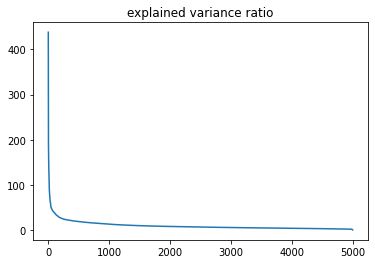

In [ ]:
# set n_components=5000 to plot this graph
#plt.plot(pipe['pca'].explained_variance_);
#plt.title('explained variance ratio');

In [ ]:
exp_test = np.load(path+'exp_gaba.npy')
exp_test = pipe.transform(exp_test)
np.save(path+'exp_test_pca', exp_test)
del exp_test

## GAN

In [4]:
random.seed(44)
np.random.seed(44)
tf.random.set_seed(44)

In [5]:
exp_train = np.load(path+'exp_train_pca.npy')

In [6]:
# oversample the non-neuronal cells
#exp_train = np.concatenate([exp_train, exp_train[-914:]], axis=0)

In [7]:
BATCH_SIZE = 500
dataset = tf.data.Dataset.from_tensor_slices(exp_train).shuffle(1000).batch(BATCH_SIZE)

In [8]:
dimension = exp_train.shape[1]

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2048, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # sigmoid function will make the range [0,1]
    model.add(layers.Dense(dimension, use_bias=True, activation='sigmoid'))

    return model

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2048, use_bias=True, input_shape=(dimension,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1))

    return model

In [60]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [61]:
#generator.summary()

In [62]:
#discriminator.summary()

In [63]:
def discriminator_loss(real_output, fake_output):
    Z = tf.reduce_sum(tf.exp(-real_output)) + tf.reduce_sum(tf.exp(-fake_output))
    total_loss = tf.reduce_sum(real_output) / BATCH_SIZE + tf.math.log(Z)
    return total_loss

In [64]:
def generator_loss(real_output, fake_output):
    Z = tf.reduce_sum(tf.exp(-real_output)) + tf.reduce_sum(tf.exp(-fake_output))
    total_loss = (tf.reduce_sum(real_output) + tf.reduce_sum(fake_output)) / (BATCH_SIZE * 2) + tf.math.log(Z)
    return total_loss

In [65]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [66]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 128])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(real_output, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [67]:
def train(dataset, epochs, delta):
    loss_hist = []
    gen_loss_hist = []
    disc_loss_hist = []
    for epoch in range(epochs):
        start = time.time()

        gen_loss = 0
        disc_loss = 0
        for data in dataset:
            loss1, loss2 = train_step(data)
            gen_loss += loss1
            disc_loss += loss2

        if (epoch+1)%20 == 0:
            print('Time for epoch {} is {} sec. Loss is {}'.format(epoch + 1, time.time()-start, gen_loss+disc_loss))
        
        loss_hist.append(gen_loss+disc_loss)
        gen_loss_hist.append(gen_loss)
        disc_loss_hist.append(disc_loss)
        if epoch > 2:
            if abs(loss_hist[-1] - loss_hist[-2]) < delta and abs(loss_hist[-2] - loss_hist[-3]) < delta:
                print('Final Loss is {}'.format(loss_hist[-1]))
                return loss_hist, gen_loss_hist, disc_loss_hist

    print('Final Loss is {}'.format(loss_hist[-1]))
    return loss_hist, gen_loss_hist, disc_loss_hist

In [68]:
hist = train(dataset, epochs=1000, delta=0.1)

Time for epoch 20 is 0.8261170387268066 sec. Loss is 158.27883911132812
Time for epoch 40 is 0.832747220993042 sec. Loss is 156.03543090820312
Time for epoch 60 is 0.821199893951416 sec. Loss is 170.15554809570312
Time for epoch 80 is 0.8006176948547363 sec. Loss is 162.09507751464844
Time for epoch 100 is 0.8150098323822021 sec. Loss is 163.24652099609375
Time for epoch 120 is 0.8194844722747803 sec. Loss is 177.02870178222656
Time for epoch 140 is 0.8119997978210449 sec. Loss is 186.67312622070312
Time for epoch 160 is 0.8182864189147949 sec. Loss is 168.5830535888672
Time for epoch 180 is 0.7954089641571045 sec. Loss is 163.35147094726562
Time for epoch 200 is 0.8586599826812744 sec. Loss is 155.52195739746094
Time for epoch 220 is 0.8557512760162354 sec. Loss is 152.32627868652344
Time for epoch 240 is 0.8506238460540771 sec. Loss is 155.13551330566406
Time for epoch 260 is 0.852470874786377 sec. Loss is 150.07757568359375
Time for epoch 280 is 0.8639121055603027 sec. Loss is 149.1

In [69]:
exp_gen = generator(tf.random.normal([1000,128]))

In [70]:
np.save(path+'exp_gen1', exp_gen)

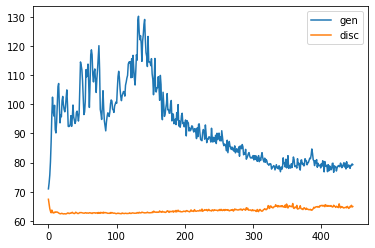

In [71]:
plt.plot(hist[1]);
plt.plot(hist[2]);
plt.legend(['gen', 'disc']);

## Evaluation

### PCA + Visualization

In [55]:
pipe = pickle.loads(pickle.load(open(path+'pipe', 'rb')))

In [56]:
tmat = pipe['pca'].components_.transpose()

In [72]:
exp_gen = pipe.inverse_transform(exp_gen)
exp_gen = pipe['scaler1'].transform(exp_gen) @ tmat[:, :2]

In [58]:
exp_glut = pipe['scaler1'].transform(np.load(path+'exp_glut.npy')) @ tmat[:, :2]
exp_non = pipe['scaler1'].transform(np.load(path+'exp_non.npy')) @ tmat[:, :2]
exp_gaba = pipe['scaler1'].transform(np.load(path+'exp_gaba.npy')) @ tmat[:, :2]

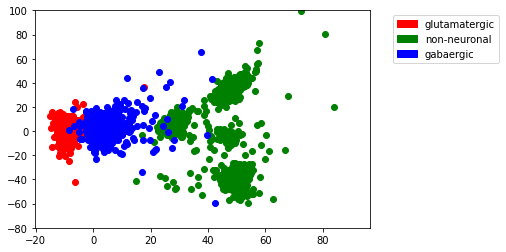

In [ ]:
# red: glutamatergic
x, y = list(zip(*exp_glut[:1000]))
plt.scatter(x, y, c='r', alpha=1)
# green: non-neuronal
x, y = list(zip(*exp_non[:1000]))
plt.scatter(x, y, c='g', alpha=1)
# blue: gabaergic
x, y = list(zip(*exp_gaba[:1000]))
plt.scatter(x, y, c='b', alpha=1)

#plt.xlim(-2, 2);
plt.ylim(-80, 100);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
plt.legend(handles=[patch1, patch2, patch3], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()

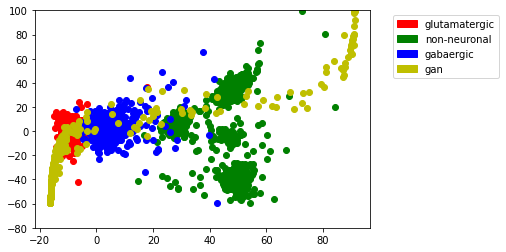

In [59]:
# red: glutamatergic
x, y = list(zip(*exp_glut[:1000]))
plt.scatter(x, y, c='r', alpha=1);
# green: non-neuronal
x, y = list(zip(*exp_non[:1000]))
plt.scatter(x, y, c='g', alpha=1);
# blue: gabaergic
x, y = list(zip(*exp_gaba[:1000]))
plt.scatter(x, y, c='b', alpha=1);
# yellow: gan
x, y = list(zip(*exp_gen[:1000]))
plt.scatter(x, y, c='y', alpha=1);

#plt.xlim(-10, 10);
plt.ylim(-80, 100);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()